In [36]:
import sys
sys.path.append("../Display/")
from display import STMimagePlot
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display
import pySPM
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import copy
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA, NMF,IncrementalPCA
from scipy.linalg import svd
from sklearn.cluster import KMeans
from sklearn import decomposition

## Automatic microscopic image analysis by moving window local Fourier Transform and Machine Learning

![image](image_from_paper/moving_window.png)

In [3]:
mydir,myFolder,fileName="../../../STMdata","20230223","SiC053.sxm"
filePath=join(mydir,myFolder,fileName)
databaseName="../../STMdata.db"
filePath=join(mydir,myFolder,fileName)
Myimage=STMimagePlot(filePath=filePath,dataseName=databaseName)
image=Myimage.get_image_value(channel="Z_forward")

../../STMdata.db
SUCCESS---------SELECT List_ID FROM STMdataLists WHERE UpdateFilePath='../../../STMdata/20230223/SiC053.sxm'
../../STMdata.db
SUCCESS---------SELECT List_ID FROM STMdataLists WHERE UpdateFilePath='../../../STMdata/20230223/SiC053.sxm'
SUCCESS---------SELECT SCAN_PIXELS from STMimageInfo WHERE List_ID=5652
SUCCESS---------SELECT Z_forward from STMimageValue WHERE List_ID=5652


In [4]:
from skimage.util import view_as_windows
from scipy.fft import fftshift, fft2,ifftshift,ifft2,fft,fftfreq
from scipy.signal import hann

def read_file(filePath):
    SXMfile=pySPM.SXM(filePath)
    header=SXMfile.header
    Bias=header['BIAS'][0][0]
    Curr=header['Z-CONTROLLER'][1][3]
    Z_image=SXMfile.get_channel('Z')
    Z_image.correct_median_diff()
    Z_image.correct_lines()
    x_n,y_n=Z_image.size["real"]["x"]*1e9,Z_image.size["real"]["y"]*1e9
    y_p,x_p=Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"]
    print("the file is {0},\r\nthe Bias is {1} V,the current is {4} A, the size is {2}*{2} nm,the resolution is {3}*{3} pix ".format(filePath,float(Bias),int(x_n),x_p,Curr))
    return Z_image,x_n

def slide_win_FT(windows):

    imageshape=windows.shape
    windows=windows.reshape(-1,imageshape[-2],imageshape[-1])
    windows_FT=np.empty(windows.shape)
    for i,image in enumerate(windows):
        Z_image= pySPM.SPM_image(image)
        Z_image.correct_median_diff()
        Z_image.correct_lines()
        image=Z_image.pixels
        image_FT=my_FFT(image)
        windows_FT[i]=image_FT
    windows_FT=windows_FT.reshape(imageshape)
    
    print("the shape of moving windows:", windows_FT.shape)
    
    arg=[[60,60],[60,62],[60,64],[50,60],[60,63],[50,64],[60,40],[50,62],[60,20]]
    

    plt.figure(figsize=[15,15])
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(windows_FT[arg[i][0]][arg[i][1]])
        plt.title("Slide Window."+str(arg[i][0])+"*"+str(arg[i][1]))
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    plt.show()
    return windows_FT


def slide_Win(image,window_size = (32, 32),stride = 32):
    image=image
    window_size = window_size
    stride = stride
    # Extract windows from the image
    windows = view_as_windows(image, window_size, stride)
    
    print("the shape of moving windows:", windows.shape)
    
    arg=[[60,60],[60,62],[60,64],[50,60],[60,63],[50,64],[60,40],[50,62],[60,20]]
    

    plt.figure(figsize=[15,15])
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(windows[arg[i][0]][arg[i][1]])
        plt.title("Slide Window."+str(arg[i][0])+"*"+str(arg[i][1]))
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    plt.show()
    return windows


def recover_Win(windows,image,stride=32):
    recons_img=np.zeros(shape=image.shape)
    for x in range(windows.shape[0]):
        for y in range(windows.shape[1]):
            x_pos,y_pos=x*stride,y*stride
            recons_img[x_pos:x_pos+windows.shape[2], y_pos:y_pos+windows.shape[3]]=windows[x,y]
    plt.figure(figsize=(15,25))
    plt.subplot(1,2,1)
    plt.imshow(recons_img, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    print("the reconstructed image equal to original image:",(recons_img==image).all())
    return recons_img


def my_FFT(img):
    x_p=img.shape[0]
    image_bw=(img-img.min())/(img.max()-img.min())
    image_bw=img
    window_hann = image_bw * hann(x_p, sym=True)
    ft = np.fft.fftshift(np.fft.fft2(window_hann))
    power_spectrum = np.abs(ft) ** 2
    return (power_spectrum-power_spectrum.min())/(power_spectrum.max()-power_spectrum.min())



def display_topo(image,fig,ax,x_n,y_n,title="SiC",isaxis=False,isbar=True,scalecolor="white",scalesize=0.3,cmap="Blues_r"):
    #image=gaussian_filter(image,sigma=1)
    Z_image= pySPM.SPM_image(image)
    Z_image.correct_median_diff()
    Z_image.correct_lines()
    (y_p,x_p)=image.shape
    Z_image.size["real"]["x"],Z_image.size["real"]["y"]=x_n*1e-9,y_n*1e-9
    Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"]=y_p,x_p
    img=Z_image.show(ax=ax,sig=None,cmap=cmap)
    if not isaxis:
        ax.axis ('off')
    Vmin=np.ndarray.min(Z_image.pixels) 
    Vmax=np.ndarray.max(Z_image.pixels) 
    cb=fig.colorbar(img,ax=ax,orientation="vertical",pad=0.02,shrink=0.8) 
    cb.ax.yaxis.set_tick_params(size=0.8,labeltop=True) 
    cb.set_ticks([Vmax,Vmin])
    cb.set_ticklabels(["High","Low"])
    scale=int(x_n/10) 
    scalebar=AnchoredSizeBar(ax.transData,scale*2,"{0} nm".format(scale*2),"lower right",pad=1,sep=3,color=scalecolor,label_top=True,frameon=False,size_vertical=scalesize)
    if isbar:
        ax.add_artist(scalebar)
    ax.set_title(title) 
    return img


def display_FT(Z_fft,fig,ax,x_n=20,x_p=256,zoomValue=80,isaxis=True,isbar=True,title="FT image",cmap="gray_r"):
    x_n,y_n=x_n,x_n
    d=x_n/zoomValue #Sample spacing 
    y_p,x_p=x_p,x_p
    y_freq=np.fft.fftshift(np.fft.fftfreq(y_p,d)) 
    x_freq=np.fft.fftshift(np.fft.fftfreq(x_p,d)) 
    extent=[x_freq[0],x_freq[-1],y_freq[0],y_freq[-1]]
    if not isaxis:
        ax.axis("off")

    lattice_SiC=0.307
    r_SiC=1/lattice_SiC
    
    Z_fft=pySPM.zoom_center(Z_fft, sx=zoomValue, sy=zoomValue) 
    real={"x":-x_freq[0]+x_freq[-1],"y":y_freq[-1]-y_freq[0],"unit":"2pi/nm"} 
    Z_fft_image=pySPM.SPM_image(Z_fft,real=None) 
    scalebar2=AnchoredSizeBar(ax.transData, r_SiC/6,r'$1/6a^{-1}$',"lower right",pad=1,sep=3,color="black",label_top=True,frameon=False,size_vertical=0.01)
    if isbar:
        ax.add_artist(scalebar2)
    x=r'$q_x/2\pi$ $(nm^{-1})$'
    y=r'$q_y/2\pi$ $(nm^{-1})$'
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title("The FFT image of kagome lattice") #ax2.set_extent(extent)
    img=ax.imshow(Z_fft,origin="lower",extent=extent,cmap=cmap)
    Vmin=np.ndarray.min(Z_fft_image.pixels) 
    Vmax=np.ndarray.max(Z_fft_image.pixels) 
    cb=fig.colorbar(img,ax=ax,orientation="vertical",pad=0.02,shrink=0.8) 
    cb.ax.yaxis.set_tick_params(size=0.8,labeltop=True) 
    cb.set_ticks([Vmax,Vmin])
    cb.set_ticklabels(["High","Low"])
    ax.set_title(title)



the file is ../../../STMdata/20230223/SiC053.sxm,
the Bias is -2.5 V,the current is 3.000E-11 A, the size is 20*20 nm,the resolution is 512*512 pix 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Pyt

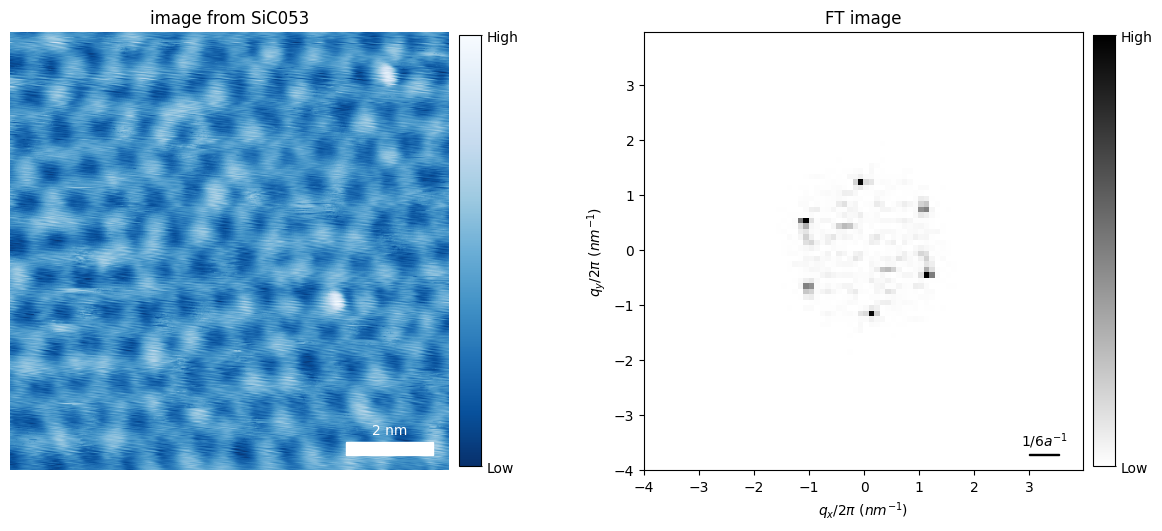

In [5]:
Z_image,x_n=read_file(filePath)
image=Z_image.pixels
fig,ax=plt.subplots(1,2,figsize=(15,7))
display_topo(image,fig,ax[0],x_n=10,y_n=10,title="image from SiC053")
my_image_FT=my_FFT(img=image)
display_FT(my_image_FT,fig,ax[1],x_n=10)

the shape of moving windows: (193, 193, 128, 128)


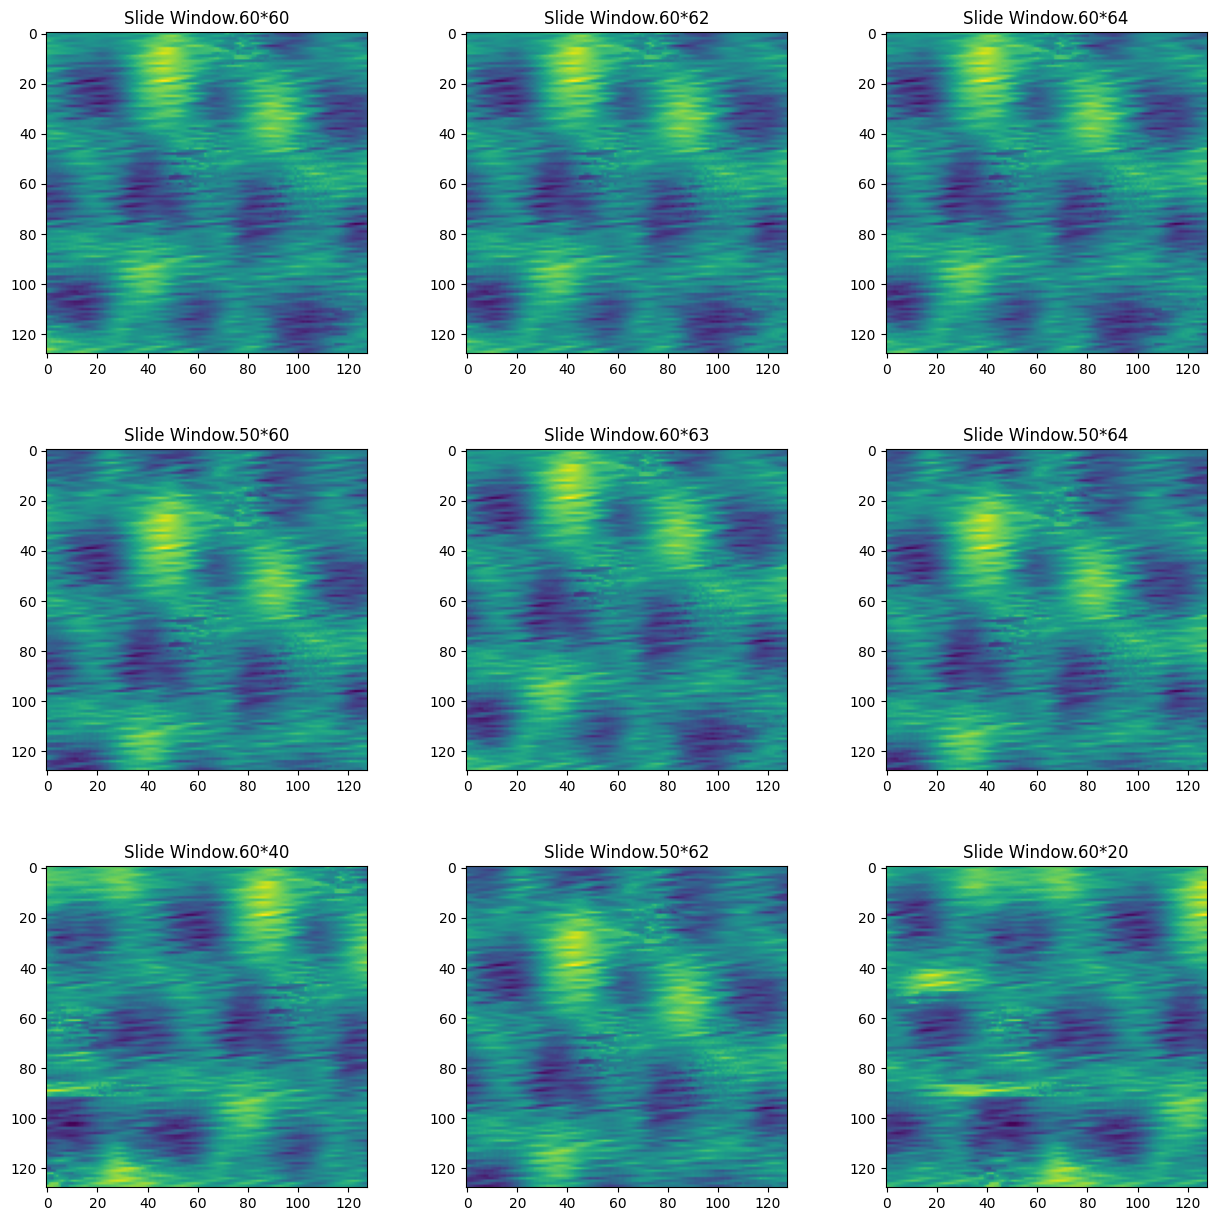

In [6]:
window_size = (128, 128)
stride = 2
windows=slide_Win(image,window_size = window_size,stride = stride)

the shape of moving windows: (193, 193, 128, 128)


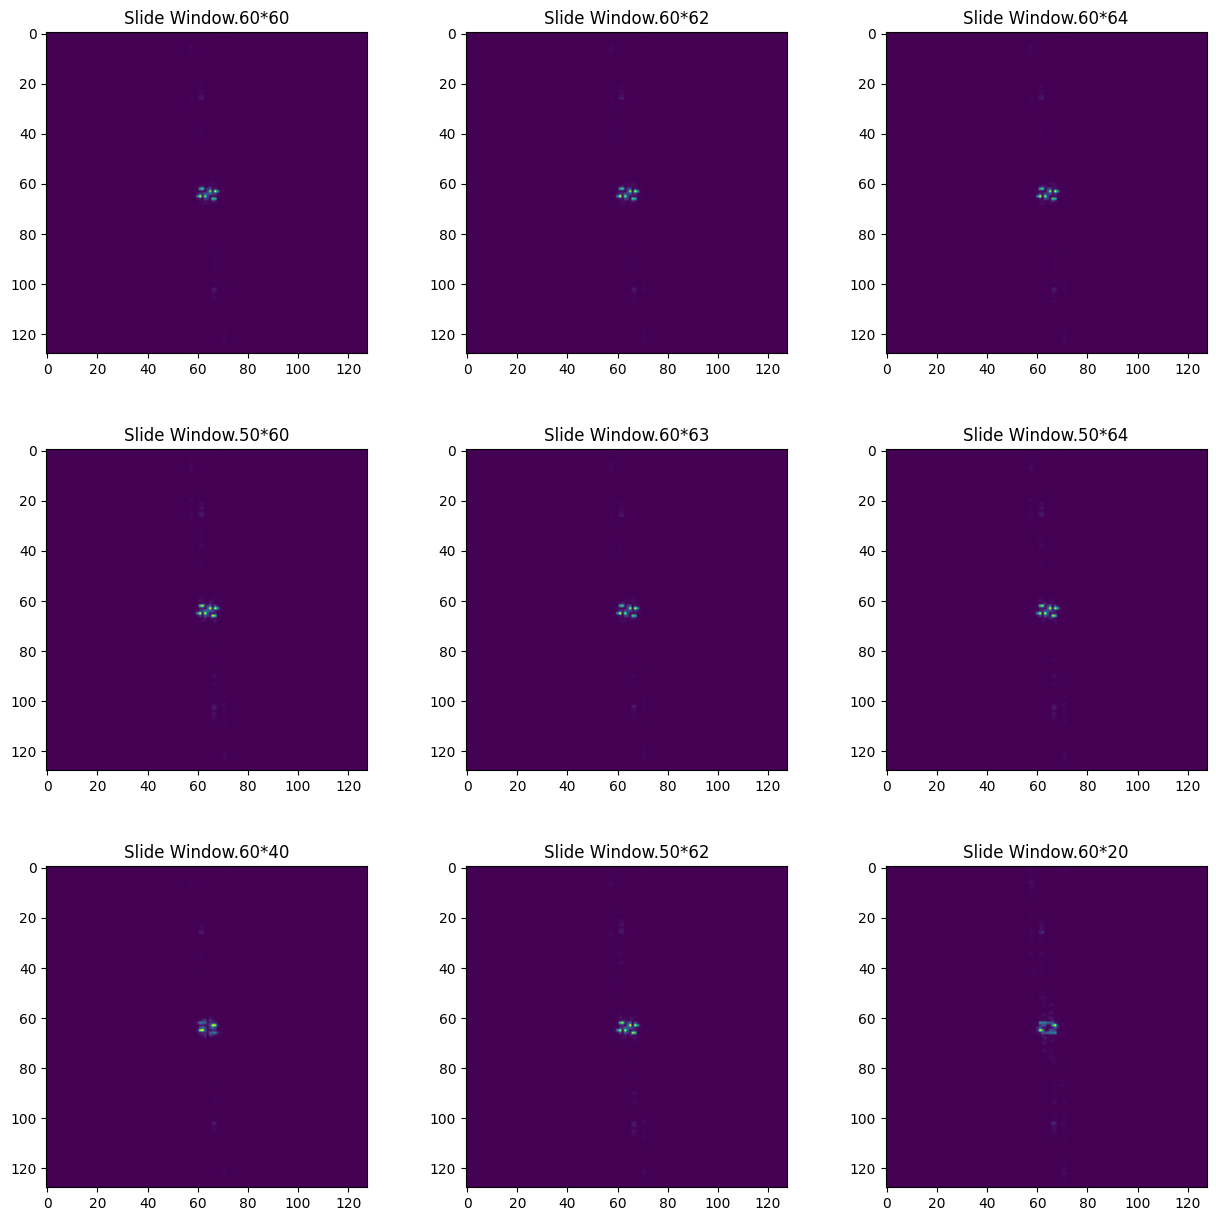

In [7]:
windows_FT=slide_win_FT(windows)


In [8]:
win_2d=windows.reshape(-1,windows.shape[-2],windows.shape[-1])
win_2d_FT=windows_FT.reshape(-1,windows.shape[-2],windows.shape[-1])
combine_2d=np.stack((win_2d,win_2d_FT),axis=-1)
print(combine_2d.shape)

(37249, 128, 128, 2)


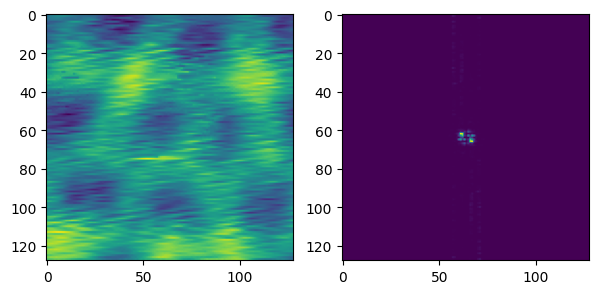

In [9]:
fig,ax=plt.subplots(1,2,figsize=(7,15))
ax[0].imshow(combine_2d[200,:,:,0])
ax[1].imshow(combine_2d[200,:,:,1])

In [27]:

image_array = combine_2d.reshape(win_2d.shape[0], -1)
print(image_array.shape)

# Perform PCA with 30 components
n_components =100
pca = PCA(n_components=n_components)
pca.fit(image_array)

# Transform the images using the PCA components
image_transformed = pca.transform(image_array) 
plt.show()

(37249, 32768)


Number of components explaining 90% variance:12


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Pyt

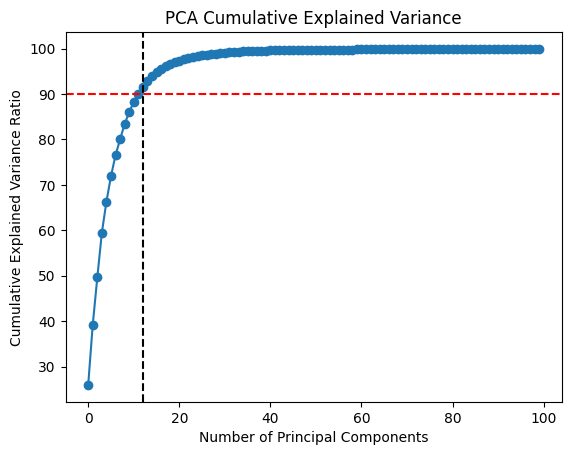

In [29]:


var_cumu=np.cumsum(pca.explained_variance_ratio_)*100
k=np.argmax(var_cumu>90)
print("Number of components explaining 90% variance:"+str(k))
plt.plot(var_cumu, marker='o')
plt.axvline(x=k,color="k",linestyle="--")
plt.axhline(y=90,color="r",linestyle="--")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance')
plt.show()



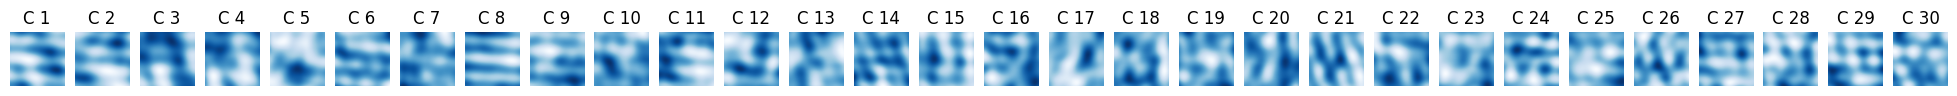

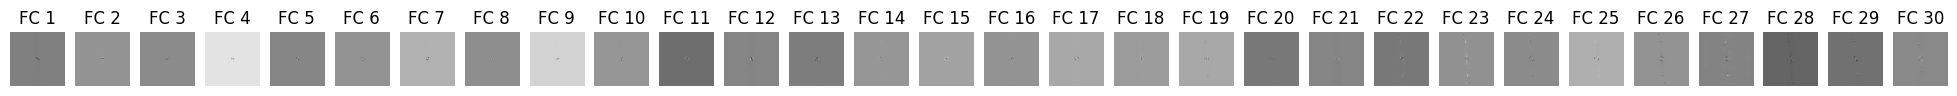

In [19]:
plt.figure(figsize=[25,25])
# Show the three main components
for i in range(n_components):
    component = pca.components_[i]
    component_image = component.reshape(128,128,2)
    plt.subplot(1, n_components, i+1)
    plt.imshow(component_image[:,:,0], cmap='Blues_r')
    plt.axis('off')
    plt.title(f'C {i+1}')
    
    

plt.figure(figsize=[25,25])
for i in range(n_components):
    component = pca.components_[i]
    component_image = component.reshape(128,128,2)
    plt.subplot(1, n_components, i+1)
    plt.imshow(component_image[:,:,1], cmap='gray_r')
    plt.axis('off')
    plt.title(f'FC {i+1}')